In [67]:
%matplotlib inline
import math

import numpy as np
import matplotlib.pyplot as plt

from linalg_helper import *
from plot_helper import *

# System Generation

First, we'll simulate a system with lots of dimensions, some unstable eigenvalue and all others stable

In [82]:
dim = 1000
A = make_random_diagonal_matrix(dim, 1.1, 0.7, 1)

from heapq import nlargest

how_many_big = 10

print('{0} largest eigenvalues of matrix'.format(how_many_big))
for e in nlargest(how_many_big, np.diagonal(A)):
    print(e)

10 largest eigenvalues of matrix
1.4220406669480468
0.9005402518579269
0.8007298166580943
0.25024610070665876
0.18679187371983522
0.0936155399956382
0.078415455344338
0.06419346994988602
0.046963444696784346
0.04648472000159852


In [83]:
C = make_random_subspace(dim, dim)
x_init = make_random_direction(dim)
x = simulate_free_response(A, 20, x_init)
x_obs = (C.dot(x.T)).T
#print('\nActual states')
#plot_state_trace(x)
#print('Observed through matrix')
#plot_state_trace(x_obs)

Given random rotation/unitary transform of the state (random unitary C matrix), all outputs will seem to diverge, or begin exhibiting the diverging eigenvalue. Another thing to look at later, when we start doing control, is if we get similar qualitative results/equivalency by simulating with random eigenvectors vs. some randomly rotated actuation vector.

In [84]:
# Make the random unknown matrix of eigenvectors
Q = make_random_subspace(dim, dim)

In [85]:
# Set how many time steps we want to simulate the system for
N = 1000
# Compute the random A matrix for which we don't know the eigenvalues or eigenvectors
A_bar = Q @ A @ Q.T

# Find largest eigenvalue and corresponding eigenvector
max_eig_index = max(zip(range(dim), np.diagonal(A)), key=lambda x: x[1])[0]
max_eigvec = np.array(Q[:,max_eig_index])

# This is where I set the initial state
#x_init = np.array(max_eigvec)
x_init = make_random_direction(dim)

# Simulate and plot the state evolution without input for a short time and a long time
x1 = simulate_free_response(A_bar, 20, x_init)
#plot_state_trace(x1)
x2 = simulate_free_response(A_bar, N, x_init)
#plot_state_trace(x2)

Dominating behavior of largest eigenvalue doesn't show up until after a while in the unstable system. Does seem to show up with ~k*dim steps.

Having one coordinate transform (Q) in between our random observation direction of the state and just observing it in the diagonalized form doesn't seem all that different. Is it?

# Looking at random projections of the state

In [86]:
trials = 1000
obs_vecs = np.zeros([N*trials, dim])

for i in range(N*trials):
    obs_vecs[i,:] = make_random_direction(dim).reshape([1, dim])

In [87]:
obs = np.zeros([N, 0])

for i in range(trials):
    obs_curr = obs_vecs[N*i:N*(i+1), :]
    obs_vec = np.einsum('ij,ij->i', obs_curr, x2)
    obs = np.hstack((obs, obs_vec.reshape([N, 1])))

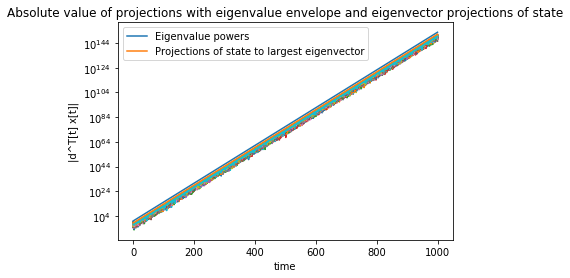

In [105]:
t_final = N
eig = max(np.diagonal(A))
lambda_vec = np.array([(eig ** n) for n in range(t_final)])
for i in range(trials):
    plt.plot(range(t_final), abs(obs[0:t_final, i]))
# eigenvalue power envelope divided by sqrt.(dim)
plt.plot(range(t_final), lambda_vec)
# projections of state to the largest eigenvector
plt.plot(range(t_final), abs(x2[0:t_final,:].dot(Q[:,0])))
plt.legend(['Eigenvalue powers', 'Projections of state to largest eigenvector'])

plt.yscale('log')
plt.title('Absolute value of projections with eigenvalue envelope and eigenvector projections of state')
plt.xlabel('time')
plt.ylabel('|d^T[t] x[t]|');

Question: Why do the observations display a trend mostly aligned with the eigenvector even if we're mostly orthogonal (Based on the histogram below)? How does the variance of the projections change with dimensionality?

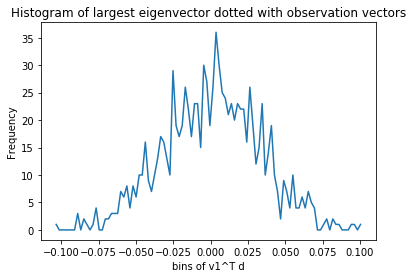

In [90]:
dots_big_eigvec = obs_vecs[0:N,:].dot(max_eigvec)
plot_histogram(dots_big_eigvec, N//10)
plt.title('Histogram of largest eigenvector dotted with observation vectors')
plt.xlabel('bins of v1^T d')
plt.ylabel('Frequency');

Is the envelope of our observations of interest? Yes! (empirircally so) There's something happening here, but maybe there's a really simple straightforward explanation. Maybe it's that since the largest state is the one blowing up, the observation vectors that give the maximal dot products on the fringe/envelope will be in greatest alignment with the blowing up eigenvector? So if we can isolate the envelope somehow (look to make the variation convex)

Based on the histogram above, it seems like it's not actually the case that we even get close to being in alignment with the eigenvector, but we still get the trend anyway. That's weird.

It looks like it's possible to under estimate the eigenvalue based on some part of the dot products. For now, maybe try to convexify (move all points that are lower in the middle of a set of 3 to the average of the 2 points on the exterior) Additionally, would orthogonalization help at all? (Since after n observations due to probabalistic orthogonality, we're bound to be able to write all subsequent measurements in terms of a basis - not necessarily orthogonal?)

Can we look at with k largest eigenvalues, if we can see piece wise linearity based on initial conditions and certain eigenvalues dominating others in the short time span as they grow?

Why is the envelope sometimes exceeded? Is this a shift/translation in log/multiply in normal scale, or is this something more fundamental? Does this interfere with upper bounds? (Probably because I didn't use a normalized state prior to this, was using just [1, 1, ..., 1]

## "Smoothing" by maximums

The code below looks to see if smoothing would be more useful for finding the eigenvalue. The hope is to make an linear envelope in the semilog scale by somehow "convexifying" the projection trend.

In [91]:
# obs1 = np.array(obs[:,0])

# fig, ax = plt.subplots(2)
# ax[0].plot(range(t_final), obs1[0:t_final])
# ax[0].set_yscale('log')
# ax[0].set_title('First set of observations from 0 to t_final')
# ax[1].plot(range(N), obs1)
# ax[1].set_yscale('log')
# ax[1].set_title('First set of observations from 0 to N')
# fig.subplots_adjust(hspace=0.5)

# for i in range(N-1):
#     if obs1[i+1] < obs1[i]:
#         obs1[i+1] = obs1[i]

# fig, ax = plt.subplots(2)
# ax[0].plot(range(t_final), obs1[0:t_final])
# ax[0].set_yscale('log')
# ax[0].set_title('First set of smoothed observations from 0 to t_final')
# ax[1].plot(range(N), obs1)
# ax[1].set_yscale('log')
# ax[1].set_title('First set of smoothed observations from 0 to N')
# fig.subplots_adjust(hspace=0.5)

# Just try regression on the unsmoothed projections to get the eigenvalue

For many trials, compute the slope (by a linear regression), then look at the distribution of the slopes for different sets of observations to see if the eigenvalue is roughly distributed about the maximum.

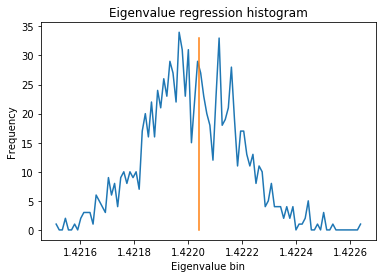

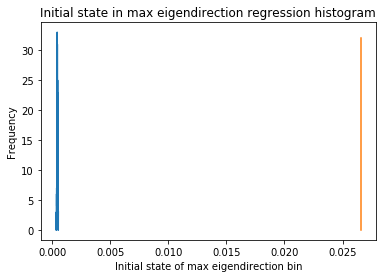

In [92]:
time = np.array(range(N)).reshape([N, 1])
A_regress = np.hstack((time, np.ones([N, 1])))

r_result = np.zeros([trials, 2])

for i in range(trials):
    b_regress = np.log(np.abs(np.array(obs[:,i])).reshape([N, 1]))
    slope, _, _, _ = np.linalg.lstsq(A_regress, b_regress, rcond=None)
    r_result[i,:] = slope.reshape([1, 2])
    
estimated_eigs = np.exp(r_result[:,0])
estimated_initial = np.exp(r_result[:,1])

plot_histogram(estimated_eigs, N//10, eig)
plt.title('Eigenvalue regression histogram')
plt.xlabel('Eigenvalue bin')
plt.ylabel('Frequency')

plot_histogram(estimated_initial, N//10, abs(x2[0,:].dot(max_eigvec)))
plt.title('Initial state in max eigendirection regression histogram')
plt.xlabel('Initial state of max eigendirection bin')
plt.ylabel('Frequency');

Obviously the bottom is a bad distribution for the initial state because we did regression on the entire data and not just the convexified/envelope part

Does dimensionality seem to affect variance? Additionally, initial condition/shift of the projections seems to affect the mean of the regression distribution. Maybe it's the variance of the projections that affects the mean of the eigenvalue regression?

# Just try regression on the observations with estimated eigenvalues to see if the eigenvector is recoverable

In [96]:
eig_vec_result = []

#Knowing the initial state doesn't seem to help, but complete alignment of the
#initial state with the eigenvector seems to help. Why?
#max_eig_init = x2[0, :] @ max_eigvec

#try gaussian elmination/not inversion if square

later = 10

for i in range(trials):
    scaled_obs = np.array(obs[later:, i])
    for j in range(N-later):
        scaled_obs[j] /=  estimated_eigs[i] ** (j+later)
    vec_result , _, _, _ = np.linalg.lstsq(obs_vecs[N*i+later:N*(i+1), :], scaled_obs, rcond=None)
    vec_result /= np.linalg.norm(vec_result)
    eig_vec_result.append(vec_result)

Best eigenvector estimate characteristics
-Error norm: 1.999267057745321
-Angle in degrees: [176.89757871]
Worst eigenvector estimate characteristics
-Error norm: 1.7515789645418418
-Angle in degrees: [122.27709745]
Histogram shows distribution of fits after waiting 10 time steps
The initial state is -0.026550792609220473 as much along the maximum eigenvector


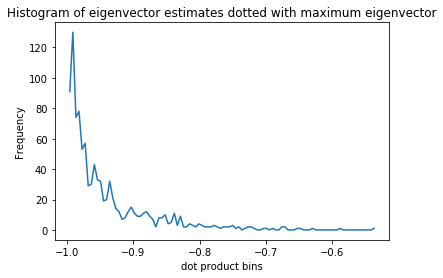

In [108]:
eig_vec_result = np.array(eig_vec_result)
dotprods = eig_vec_result.dot(max_eigvec)
plot_histogram(dotprods, trials//10)
plt.title('Histogram of eigenvector estimates dotted with maximum eigenvector')
plt.ylabel('Frequency')
plt.xlabel('dot product bins')
good_eigvec_index = max(enumerate(dotprods), key=lambda x: abs(x[1]))[0]
good_eigvec = eig_vec_result[good_eigvec_index, :]

bad_eigvec_index = min(enumerate(dotprods), key = lambda x: abs(x[1]))[0]
bad_eigvec = eig_vec_result[bad_eigvec_index, :]

min_error = np.linalg.norm(max_eigvec-good_eigvec)
best_angle = np.arccos(max_eigvec @ good_eigvec.reshape([dim, 1])) * 180/np.pi
max_error = np.linalg.norm(max_eigvec-bad_eigvec)
worst_angle = np.arccos(max_eigvec @ bad_eigvec.reshape([dim, 1])) * 180/np.pi
print('Best eigenvector estimate characteristics')
print('-Error norm: {0}'.format(min_error))
print('-Angle in degrees: {0}'.format(best_angle))
print('Worst eigenvector estimate characteristics')
print('-Error norm: {0}'.format(max_error))
print('-Angle in degrees: {0}'.format(worst_angle))
print('Histogram shows distribution of fits after waiting {0} time steps'.format(later))
print('The initial state is {0} as much along the maximum eigenvector'.format(max_eigvec @ x_init))

Our eigenvector estimate was bad when we were trying to do a least squares on exponential curve. Why? Based on log plots of the observations vs. the dots with the estimated eigenvectors, the regression fit only works for later, and not earlier times. Also, since I realized for the eigenvalue fit earlier, I did a log. How can I apply a log here? I just normalized by the eigenvalues by dividing all equations by the eigenvalue powers, and this gives pretty decent results for 'low' dimensionality (dim = 100). Also, I used the actual eigenvalue rather than an estimate - it looks like a really skewed plot toward -1 or 1

Let's crank up both the number of trials and the dimensions and also the number of large eigenvalues and see if its robust to those aspects.

So changing the number of dimensions seems to be the main factor in making it skew! interesting!

The lower the dimension, the more likely we are to see the skew to 1 or -1. The higher the dimension, the more likely it'll be centered around 0. I wonder if it doesn't have anything to do witht he initial condition as well. Try the initial condition as being 100% aligned with the biggest eigenvector - I did this for maybe dim = 100? seemed to work better and got more of the skew to the 1.0 or -1.0.

If there's a link between the initial state and the recovery of the eigenvalue, then it could have to do with the probalistic amount of the initial state in the direction of the eigenvector, which would be like $\frac{1}{\sqrt{\text{dim}}}$

Since it seems like it happens sometimes, maybe I just haven't done enough trials.

The trials seem to point towards it being the initial condition ~~and the gap between the projections and the eigenvector projections.~~ Maybe I should only use later measurements?

I think it's literally the initial condition. To check, do a regression after discarding maybe the first N/10 or so time steps.

Also, make a plot that abstracts over different choices of initial state. and how many time steps we ignore before we regress.

Also, if the initial state/decay of the system is what's causing the distribution of the estimated vectors to be mostly perpendicular, then NOT controlling and making estimates simultaneously might be intuitively better, at least not estimating until the system comes back to being mostly along the eigenvector.

Doing at only later time steps is pretty good! (seems to be more centered at slightly less than 1) So directional noise in the initial state is bad - if we have disturbances does this still work?

Also, I reduced the 100 time step wait to 5 time steps, and it seems like it does much much better. Which makes sense, since we're throwing away less data.

What wait time would work for having n large eigenvalues?

Since we can think of the relative growth of the largest eigenvalue relative to the next largest eigenvalue as being $\frac{\lambda_1}{\lambda_2}$, if we want to this component grow larger than the rest, it should grow for as many time steps as to make this at least some number of times bigger (for example, $10\times$ or $N\times$ where $N$ is the dimension)

So if $G$ is the number of times bigger that we want the largest eigenvector to be compared to all other components, it would require $\log_{\frac{\lambda_1}{\lambda_2}}{G}$ timesteps for the component to properly grow. How does this size affect the estimate?

How to control an eigenvalue that mixes into other eigenvalues?